In [1]:
import numpy as np
import scipy.sparse as sparse

block_size=16
i_size=224
o_size=256
# blocked sizes
ib_size=i_size//block_size
ob_size=o_size//block_size
# random sparsity map
layout = np.random.randint(2, size=(ib_size,ob_size))

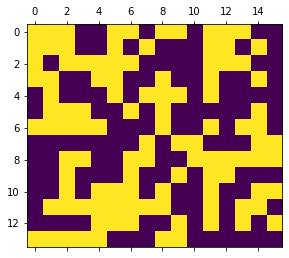

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.matshow(layout)
plt.show()

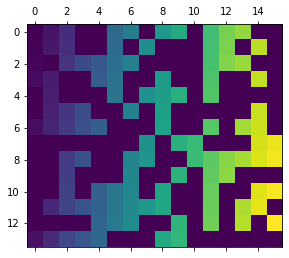

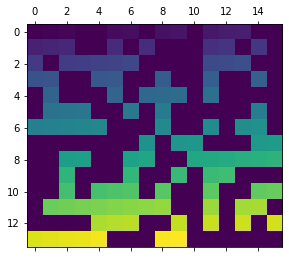

In [3]:
csr = sparse.csr_matrix(layout)
cs, ks, vs = sparse.find(csr) # ks is in sorted order by default
#print([_ for _ in zip(cs, ks)])
blocks = len(vs)
idx  = list(range(blocks))
idxT = sorted(idx, key=lambda i: cs[i]) # transposed

heat_idx = np.zeros(layout.shape)
for heat, i in enumerate(idx):
    if layout[cs[i], ks[i]]:
        heat_idx[cs[i], ks[i]] = i
heat_idxT = np.zeros(layout.shape)
for heat, i in enumerate(idxT):
    if layout[cs[i], ks[i]]:
        heat_idxT[cs[i], ks[i]] = heat
plt.matshow(heat_idx)
plt.matshow(heat_idxT)
plt.show()

In [4]:
def z_order_2d(x, y):
    answer = 0
    bits = max(len(bin(x)), len(bin(y))) - 2
    for i in range(bits):
        mshifted = 1 << i;
        shift = i
        answer |= ((x & mshifted) << shift) | ((y & mshifted) << (shift + 1))
    return answer

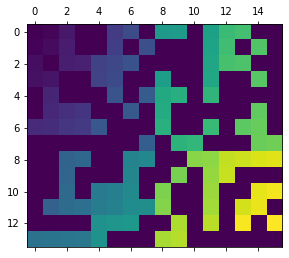

In [5]:
# Used for backprop, updating weights
updat_list = list()
blk = 0
for _, i in sorted( [ (z_order_2d(cs[i], ks[i]), i) for i in range(blocks) ] ):
    vs[i] = blk
    updat_list.append((cs[i], ks[i]))
    blk += 1
#vs = list(range(blocks))
# visualize vs
heat_idxZ = np.zeros(layout.shape)
for x, y, heat in zip(cs, ks, vs):
    heat_idxZ[x,y] = heat
plt.matshow(heat_idxZ)
plt.show()

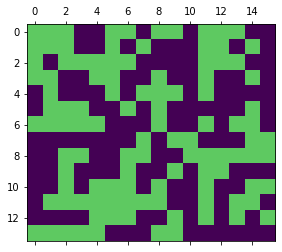

In [6]:
# vvv ignore, animation vvv
import copy
anim = []
layout_copy = copy.copy(layout) * 0.4
# ^^^^^^^^^^^^^^^^^^^^^^^^^

channels = [0 for k in range(ob_size)]
for i in idx:
    channels[ks[i]] += 1
K = ks[idx[0]]
seg_count = 0
seg  = list()
segs = list()
kset = set()
locks = 0
lockids = dict()

for i in idx:
    c, k, v = cs[i], ks[i], vs[i]
    kset.add(k)
    # check for new value of k
    if k != K:
        if len(seg):
            segs.append( (K, seg) )
            seg = list()
            seg_count += 1
        # for more than one segment we need to use spin locks to sync accumulation
        if seg_count > 1:
            locks += 1
            lockids[K] = locks
        seg_count = 0
        K = k
        
        # vvv ignore, animation vvv
        layout_copy = np.clip(layout_copy,0, 0.75)
        # ^^^^^^^^^^^^^^^^^^^^^^^^^
        
    seg.append( (c, v) )
    channels[k] -= 1
    
    max_seg = 8
    min_seg = 2
    if len(seg) >= max_seg and channels[k] >= min_seg:
        segs.append( (k, seg) )
        seg = list()
        seg_count += 1
        
        # vvv ignore, animation vvv
        layout_copy = np.clip(layout_copy,0, 0.75)
        # ^^^^^^^^^^^^^^^^^^^^^^^^^ 

    # vvv ignore, animation vvv
    layout_copy[c, k] = 1
    anim.append(copy.copy(layout_copy))
    # ^^^^^^^^^^^^^^^^^^^^^^^^^

# last k
if len(seg):
    segs.append( (k, seg) )
    seg_count += 1
    if seg_count > 1:
        locks += 1
        lockids[k] = locks

# vvv ignore, animation vvv
layout_copy = np.clip(layout_copy,0, 0.75)
anim.append(copy.copy(layout_copy))
# ^^^^^^^^^^^^^^^^^^^^^^^^^

# handle empty ks
for k in range(ob_size):
    if k not in kset:
         segs.append( (k, []) )

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
plot = ax.matshow(anim[0])
def init():
    plot.set_data(anim[0])
    return [plot]
def update(i):
    plot.set_data(anim[i])
    return [plot]

ani = FuncAnimation(fig, update, init_func=init, interval=100, frames=len(anim), blit=True)
HTML(ani.to_html5_video())

In [7]:
# now we create a lookup table
header_offset = len(segs) * 4
lut = np.empty(header_offset + len(vs)*2, dtype=np.int32)
# keep track of shared memory
lut_max = 0
offset = header_offset
for i, (k, seg) in enumerate(segs):
    # this is a lookup table header: int2 offset to the entries, segment_size, k, lock_id
    lut[i*4:(i+1)*4] = offset//2, len(seg), k, lockids.get(k, 0)
    lut_max = max(lut_max, len(seg))
    for entry in seg: # entry is c, v
        lut[offset:offset+2] = entry
        offset += 2
        
max_v = 0
for v in vs:
    if v > max_v:
        max_v = v
        
print("max v", max_v, layout.size)

print("Example LUT")
print(f"  (offset: {lut[0]*2}, size: {lut[1]}, lock_id: {lut[3]})")
print(f"  k: {lut[2]}")
print(f"  c: {lut[lut[0]*2:lut[0]*2+lut[1]*2:2]}")
print(f"  v: {lut[lut[0]*2+1:lut[0]*2+lut[1]*2+1:2]}")
print(f"Number of segments: {len(segs)}")
print(f"Allocated shared memory: {lut_max} blocks")

max v 107 224
Example LUT
  (offset: 72, size: 6, lock_id: 0)
  k: 0
  c: [ 0  1  2  3  6 13]
  v: [ 0  1  4  5 13 40]
Number of segments: 18
Allocated shared memory: 8 blocks


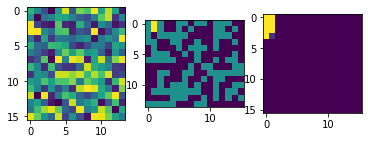

In [11]:
from matplotlib.colors import Normalize
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3)
minibatch=16
A = np.random.rand(minibatch, ib_size)
B = copy.copy(layout) * 0.5
C = np.zeros((minibatch, ob_size))
plt1 = ax1.imshow(A, norm=Normalize(0,1))
plt2 = ax2.imshow(B, norm=Normalize(0,1))
plt3 = ax3.imshow(C, norm=Normalize(0,1))

def init():
    return [plt1, plt2, plt3]

def iterate_lut(lut):
    lut_len = lut[0] * 2
    offsets = lut[0:lut_len:4]
    sizes = lut[1:lut_len:4]
    ks = lut[2:lut_len:4]
    for s, k, off in zip(sizes, ks, offsets):
        for i in range(s):
            yield k, lut[(off + i) * 2], lut[(off + i) * 2 + 1]

#lut_list = [_ for _ in iterate_lut(lut)]

# algo
# - every thread grab a LUT entry

A_orig = copy.copy(A)
B_orig = copy.copy(B)

tile_size = 4
iter_list = list()
for j_tile in range(0, ob_size, tile_size):
    for i_tile in range(0, minibatch, tile_size):
        for j_off in range(tile_size):
            for i_off in range(tile_size):
                for k in range(ib_size):
                    i = i_tile + i_off
                    j = j_tile + j_off
                    iter_list.append((i,j,k))
#iter_list = [(i, j, k) for j in range(ob_size) for i in range (minibatch) for k in range(ib_size)]

def update(_):
    global A
    global B
    i, j, k = iter_list[_]
    if k == 0:
        A = copy.copy(A_orig)
        B = copy.copy(B_orig)
    #while not B[k, j]:
    #    i, j, k = iter_list[_]
    A[i, k] = 1
    if B[k, j]:
        B[k, j] = 1
    C[i, j] += 1 / ib_size
    plt1.set_data(A)
    plt2.set_data(B)
    plt3.set_data(C)
    return [plt1, plt2, plt3]

ani = FuncAnimation(fig, update, init_func=init, interval=30, frames=100, blit=True)
HTML(ani.to_html5_video())

The backward pass, with respect to X, is a simple transpose in "compressed" space (i.e. swap cs, ks and transpose the block level gemm).

The gradient with respect to W requires using the "updat_list" we defined earlier (when z-ordering the matrix).
Just use it to look up with indices to gather from X and dY.

In [ ]:
updat_lut = np.array(updat_list, dtype=np.int32)
#print(updat_lut.flatten())

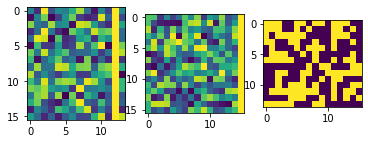

In [17]:
X = np.random.rand(minibatch, ib_size)
dY = np.random.rand(minibatch, ob_size)
dW = copy.copy(layout) * 0

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3)
plt1 = ax1.imshow(X, norm=Normalize(0,1))
plt2 = ax2.imshow(dY, norm=Normalize(0,1))
plt3 = ax3.imshow(dW, norm=Normalize(0,1))

X_orig = copy.copy(X)
dY_orig = copy.copy(dY)

K = XT.shape[1]
def update(_):
    global X
    global dY
    if _ % K == 0 or True:
        X = copy.copy(X_orig)
        dY = copy.copy(dY_orig)
    c, k = updat_list[_]
    X[0:K,c] = 1
    dY[0:K,k] = 1
    dW[c,k] = 1
    plt1.set_data(X)
    plt2.set_data(dY)
    plt3.set_data(dW)
    return [plt1, plt2, plt3]
    
ani = FuncAnimation(fig, update, init_func=init, interval=100, frames=len(updat_list), blit=True)
HTML(ani.to_html5_video())